In [1]:
# Pull in data and save it to a DataFrame

import pandas as pd

# Replace this with the path to your CSV file
file_path = '/Users/christopherfrye/Downloads/climate_risk.csv'

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

# Define climate text variables
climate_cols = [
    'tran_risk_w_std', 'tran_risk_pro_w_std', 'tran_risk_npro_w_std',
    'phy_risk_acute_w_std', 'phy_risk_chronic_w_std'
]

# Descriptive labels for plotting
climate_labels = {
    'tran_risk_w_std': "Total Transition Risk Mentions",
    'tran_risk_pro_w_std': "Proactive Transition Talk (w/ 'invest', 'develop')",
    'tran_risk_npro_w_std': "Non-Proactive Transition Talk (no action verbs)",
    'phy_risk_acute_w_std': "Acute Physical Risk (hurricanes, floods near 'risk')",
    'phy_risk_chronic_w_std': "Chronic Physical Risk (drought, heat near 'threat')"
}

# Map NAICS industry codes to sector names
def map_naics_code(code):
    if 31 <= code <= 33:
        return "Manufacturing"
    elif 44 <= code <= 45:
        return "Retail Trade"
    elif 48 <= code <= 49:
        return "Transportation and Warehousing"
    return {
        11: "Agriculture, Forestry, Fishing and Hunting",
        21: "Mining, Quarrying, and Oil and Gas Extraction",
        22: "Utilities",
        23: "Construction",
        42: "Wholesale Trade",
        51: "Information",
        52: "Finance and Insurance",
        53: "Real Estate and Rental and Leasing",
        54: "Professional, Scientific, and Technical Services",
        55: "Management of Companies and Enterprises",
        56: "Administrative and Support and Waste Management",
        61: "Educational Services",
        62: "Health Care and Social Assistance",
        71: "Arts, Entertainment, and Recreation",
        72: "Accommodation and Food Services",
        81: "Other Services",
        92: "Public Administration"
    }.get(code, "Other/Unknown")

df['naics_sector'] = df['industry_naics'].astype(int).apply(map_naics_code)

# Display the headers and the first 5 rows of the CSV
print("Headers:", df.columns.tolist())
print("\nFirst few rows:")
print(df.head())

# Display summary statistics for each column
print(df.describe())

Headers: ['gvkey', 'capex_m_lag_w', 'roaq_lag_w', 'bk_leverage_lag_w', 'ppe_lag_w', 'logatq_lag_w', 'tobin_q_w', 'qtr', 'tran_risk_w_std', 'tran_risk_pro_w_std', 'tran_risk_npro_w_std', 'phy_risk_acute_w_std', 'phy_risk_chronic_w_std', 'ticker', 'company_name', 'industry_naics', 'naics_sector']

First few rows:
   gvkey  capex_m_lag_w  roaq_lag_w  bk_leverage_lag_w  ppe_lag_w  \
0   1004       0.775370    0.091727           0.285182   0.177044   
1   1004       2.169838    0.032214           0.101650   0.194719   
2   1004       0.990099    0.029251           0.116016   0.191637   
3   1045      12.023182    0.150515           0.409038   0.527381   
4   1045       3.219026    0.171135           0.404714   0.514223   

   logatq_lag_w  tobin_q_w  qtr  tran_risk_w_std  tran_risk_pro_w_std  \
0      7.708725   1.042455    1         0.000000                  0.0   
1      7.323171   0.934373    3         0.000000                  0.0   
2      7.344202   0.930979    4         0.000000     

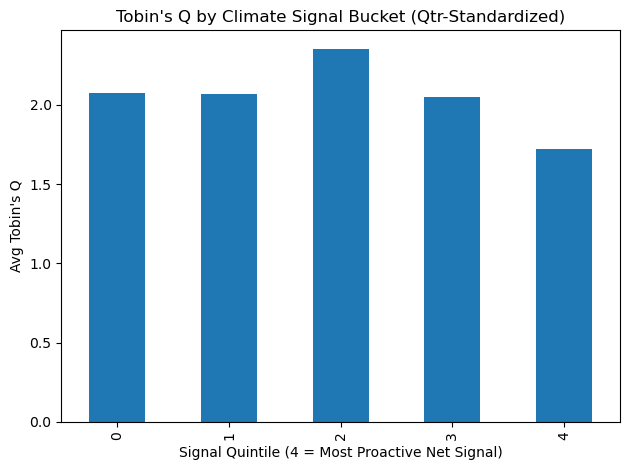

Long Tobin's Q: 1.72
Short Tobin's Q: 2.08
Q Spread (L–S): -0.36
Avg Tobin’s Q (Gaming Firms): 1.60
Avg Tobin’s Q (True Proactives): 2.01


KeyError: 'date_column'

In [2]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Signal construction -- Go long firms with high proactive climate talk, go short firms with high non-proactive climate talk; Use Tobin's Q or next-quarter return as a proxy for validation

# Create trading signal: difference between proactive and non-proactive talk
df['climate_signal'] = df['tran_risk_pro_w_std'] - df['tran_risk_npro_w_std']

# Optional: z-score normalize across quarter
df['climate_signal_z'] = df.groupby('qtr')['climate_signal'].transform(
    lambda x: (x - x.mean()) / x.std()
)

# 2) Portfolio Bucketing and Return Testing

# Bucket companies into quintiles based on climate signal
df['signal_bucket'] = pd.qcut(df['climate_signal_z'], 5, labels=False)

# Average Tobin's Q or return by signal bucket
signal_perf = df.groupby('signal_bucket')['tobin_q_w'].mean()

# Plot
signal_perf.plot(kind='bar')
plt.title("Tobin's Q by Climate Signal Bucket (Qtr-Standardized)")
plt.xlabel("Signal Quintile (4 = Most Proactive Net Signal)")
plt.ylabel("Avg Tobin's Q")
plt.tight_layout()
plt.show()

# 3) Simulate a Naive Long/Short Portfolio

# Long top 20% climate signal, short bottom 20%
long_port = df[df['signal_bucket'] == 4]
short_port = df[df['signal_bucket'] == 0]

# Average valuation (or return) difference
long_mean = long_port['tobin_q_w'].mean()
short_mean = short_port['tobin_q_w'].mean()
spread = long_mean - short_mean

print(f"Long Tobin's Q: {long_mean:.2f}")
print(f"Short Tobin's Q: {short_mean:.2f}")
print(f"Q Spread (L–S): {spread:.2f}")

# Gaming Risk

# If a firm is in top 20% proactive *and* top 20% non-proactive, flag it as possibly gaming
df['possibly_gaming'] = (df['tran_risk_pro_w_std'] > df['tran_risk_pro_w_std'].quantile(0.8)) & \
                        (df['tran_risk_npro_w_std'] > df['tran_risk_npro_w_std'].quantile(0.8))

# Compare valuation of “gaming” vs. truly proactive firms
gaming_q = df[df['possibly_gaming']]['tobin_q_w'].mean()
true_proactive_q = df[(df['tran_risk_pro_w_std'] > df['tran_risk_pro_w_std'].quantile(0.8)) &
                      (df['tran_risk_npro_w_std'] <= df['tran_risk_npro_w_std'].quantile(0.5))]['tobin_q_w'].mean()

print(f"Avg Tobin’s Q (Gaming Firms): {gaming_q:.2f}")
print(f"Avg Tobin’s Q (True Proactives): {true_proactive_q:.2f}")

# Dictionary Drift

# Mean climate talk over time (requires date column) -- have qtr but not year...
df['year'] = pd.to_datetime(df['date_column']).dt.year
drift = df.groupby('year')[['tran_risk_pro_w_std', 'tran_risk_npro_w_std']].mean()

drift.plot(marker='o')
plt.title("Average Climate Talk Over Time (Detecting Drift)")
plt.ylabel("Z-score")
plt.xlabel("Year")
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()